In [917]:
###import Libraries required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy import optimize
from sklearn.linear_model import LinearRegression
import seaborn as sns
from numpy import cos, sin, arcsin, sqrt
from math import radians

In [907]:
###import all relevant datasets and do preliminary cleaning

#import all relevant csv files
traps = pd.read_csv('train.csv')
spray = pd.read_csv('spray1.csv')
weather = pd.read_csv('weather1.csv')
daylight = pd.read_csv('Daylight Time in Chicago.csv')

#remove spray values not inside the city of Chicago and drop original index
spray = spray[spray['Longitude'] > -88].reset_index(drop=True) 

#drop unneeded attributes from weather file
weather.drop(['Depart', 'Cool', 'SnowFall', 'Water1', 'Depth', 'ResultSpeed'], axis='columns', inplace=True)

#average wind speed missing values - filled with mean value
meanVal = weather['AvgSpeed'].mean()
weather['AvgSpeed'].fillna(value=meanVal, inplace=True)
weather['AvgSpeed'] = pd.to_numeric(weather['AvgSpeed'])

#create new column in weather for daylight with left merge
daylight = daylight[['Date', 'Daylight']]
weather = pd.merge(weather, daylight, on='Date', how = 'left')

#traps df includes multiple rows for the same trap when populations exceed 50. Group all overflow rows into the same row,
MosqSum = traps.groupby(['Address', 'Date', 'Trap', 'WnvPresent'
                         , 'Species', 'Longitude', 'Latitude'])['NumMosquitos'].sum().reset_index()

#create database of locations that found West Nile Virus
WNV = MosqSum[MosqSum['WnvPresent'] == 1]

#add row for coordinates of each weather station from database information
def categorize(row):  
    if row['Station'] == 1:
        return '-87.933'
    return '-87.752'
weather['Long'] = weather.apply(lambda row: categorize(row), axis=1)
def categorise(row):  
    if row['Station'] == 1:
        return '41.995'
    return '41.786'
weather['Lat'] = weather.apply(lambda row: categorise(row), axis=1)

#convert coordinate rows to float to make useable in map
weather['Long'] = pd.to_numeric(weather['Long'])
weather['Lat'] = pd.to_numeric(weather['Lat'])

In [908]:
###use haversine formula to determine which weather station is closest to each mosquito trap

def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r
#manually input the values of the station 1 longitude and latitude into haversine formula and 
#return distance in kilometers from trap

#add distance to each station to mosquito dataframe
MosqSum['Dist_To_Station1'] = MosqSum.apply(lambda row: haversine(-87.933, 41.995, row['Longitude'], row['Latitude']), axis=1)
MosqSum['Dist_To_Station2'] = MosqSum.apply(lambda row: haversine(-87.752, 41.786, row['Longitude'], row['Latitude']), axis=1)
#subtract distance 1 from distance 2. if number is negative, the closest station is station 1, else 2
MosqSum['Dist_diff'] = MosqSum['Dist_To_Station1'].sub(MosqSum['Dist_To_Station2'], axis = 0)
result = []       
for x in MosqSum['Dist_diff']:
    if x < 0:
        result.append(1)
    else:
        result.append(2)
MosqSum['Closest_Station'] = result 

In [909]:
###create individual station dfs with specified rolling averages that can be used in regression calculations
###because traps are only checked around once per week and mosquitoes take 8-10 days from gestation to fully grown adult
###it's necessary to perform rolling averages on weather patterns to isolate correlations.

###mosquitoes are supposed to favor hot, dry conditions, but also lay their eggs in still water. my hypotheses is that
###hot dry days are better for mosquito activity, and extremely wet days help mosquitoes lay eggs

#create dictionary of code meanings to be referenced
CodeDict = {'Mist':'BR', 'Haze':'HZ', 'Rain':'RA', 'Thunderstorm':'TS', 'Fog':'FG', 'Patches':'BC'
         , 'Drizzle':'DZ', 'Smoke':'FU', 'Squall':'SQ' ,'NoLoggedCodes':'NO'}

#create new weather columns that show if weather pattern was present on a given day 
#by extracting all values from CodeSum using dictionary and multiplying by 1 to return int
for x,y in CodeDict.items():
    weather[x] = weather['CodeSum'].str.contains(y)*1
    
Station1 = weather[weather['Station']== 1].reset_index(drop=True)
Station2 = weather[weather['Station']== 2].reset_index(drop=True)

#create list of variables extracted from CodeSum column
Keys = list(CodeDict.keys())
#add variables of interest from weather df that were in their own column instead of CodeSum
Keys.extend(['PrecipTotal', 'Tavg', 'AvgSpeed', 'DewPoint', 'Daylight'])

def rollingfunction(days):
    """creates new rolling mean columns for each station for each item in Keys"""
    for x in Keys:
        Station1[f'Last{days}DayAvg{x}'] = Station1[x].rolling(days).mean()
        Station2[f'Last{days}DayAvg{x}'] = Station2[x].rolling(days).mean()
        
#create rolling means for selected days
rollingfunction(5)
rollingfunction(10)
rollingfunction(14)

WeatherCon = ['PrecipTotal','Haze','Thunderstorm','Fog','Patches','Smoke'
              ,'Squall','NoLoggedCodes','Tavg','AvgSpeed','DewPoint']

        

WeatherCon5Day = ['Last5DayAvgPrecipTotal','Last5DayAvgHaze','Last5DayAvgThunderstorm'
                  ,'Last5DayAvgFog','Last5DayAvgPatches','Last5DayAvgSmoke','Last5DayAvgSquall'
                  ,'Last5DayAvgNoLoggedCodes','Last5DayAvgTavg','Last5DayAvgAvgSpeed','Last5DayAvgDewPoint']
WeatherCon10Day = ['Last10DayAvgPrecipTotal','Last10DayAvgHaze','Last10DayAvgThunderstorm'
                   ,'Last10DayAvgFog','Last10DayAvgPatches','Last10DayAvgSmoke','Last10DayAvgSquall'
                   ,'Last10DayAvgNoLoggedCodes','Last10DayAvgTavg','Last10DayAvgAvgSpeed','Last10DayAvgDewPoint']
WeatherCon14Day = ['Last14DayAvgPrecipTotal','Last14DayAvgHaze','Last14DayAvgThunderstorm'
                   ,'Last14DayAvgFog','Last14DayAvgPatches','Last14DayAvgSmoke','Last14DayAvgSquall'
                   ,'Last14DayAvgNoLoggedCodes','Last14DayAvgTavg','Last14DayAvgAvgSpeed','Last14DayAvgDewPoint']

#convert Date values of all columns to be merged to DateTime so that they match
MosqSum['Date'] = pd.to_datetime(MosqSum['Date'])
Station1['Date'] = pd.to_datetime(Station1['Date'])
Station2['Date'] = pd.to_datetime(Station2['Date'])
#recombine stations 1 and 2 into a dataframe that now includes correct previous 10 day averages for individual stations
Combine = [Station1, Station2]
CombinedWeather = pd.concat(Combine).sort_values(['Date'], ascending=True)
#combine mosquito data with weather data based on date and closest weather station
MosqSumStations = pd.merge(MosqSum, CombinedWeather, left_on = ['Closest_Station', 'Date'], right_on = ['Station', 'Date'], how='left')

In [ ]:
def weatherconditions(days):
    WeatherCon{days}Day = []
    for x in WeatherCon:

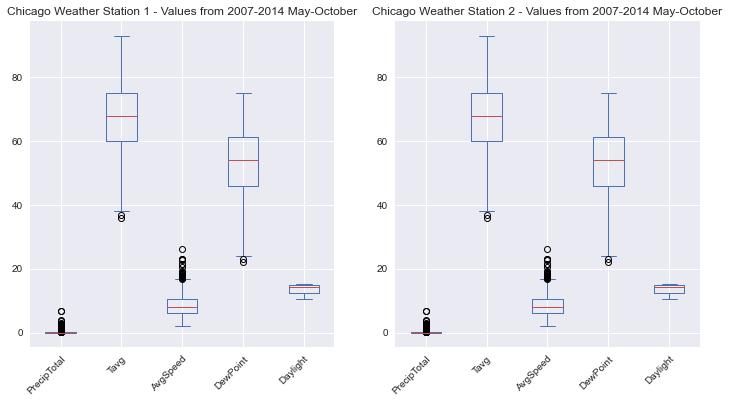

In [910]:
#view range of values for each station individually in box plot
sns.set_context('poster')
plt.style.use('seaborn')
fig, (ax1, ax2) =  plt.subplots(1, 2, sharex=False, sharey= False, figsize=(12,6)) 
Station1avg = Station1[['PrecipTotal', 'Tavg', 'AvgSpeed', 'DewPoint', 'Daylight']]
Station2avg = Station1[['PrecipTotal', 'Tavg', 'AvgSpeed', 'DewPoint', 'Daylight']]
Station1avg.plot(ax=ax1, kind='box', title = 'Chicago Weather Station 1 - Values from 2007-2014 May-October')
Station2avg.plot(ax=ax2, kind='box', title = 'Chicago Weather Station 2 - Values from 2007-2014 May-October')
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
plt.show()

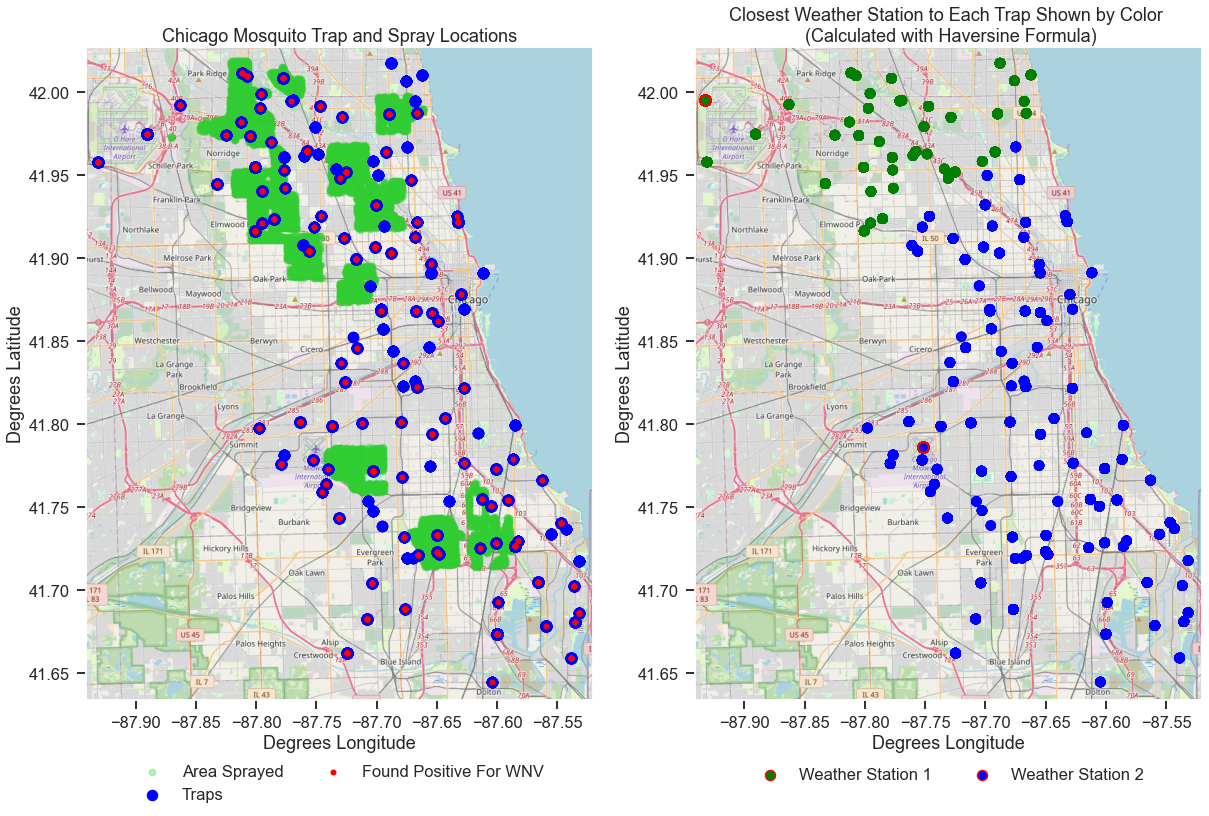

In [911]:
###use station, trap, and spray longitudes and latitudes to visually explore data

MosqSumColor = []
for x in MosqSum['Closest_Station']:
    if x == 1: MosqSumColor.append('green')
    else: MosqSumColor.append('blue')
MosqSum['MosqSumColor'] = MosqSumColor
#upload map w/ coordinates .01 degrees larger than min and max longitude and latitude values to ensure all values fit
Dimensions = (-87.9410, -87.5200, 41.6340, 42.0270)
sns.set_context('talk')
Chicago = plt.imread('map (4).png')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,12))
ax1.imshow(Chicago, extent = Dimensions, aspect ='auto')
sns.set_context()
#add spray, traps, WNV positive, and station locations
ax1.scatter(spray.Longitude, spray.Latitude, c='limegreen', alpha = .3, s=40, label='Area Sprayed')
ax1.scatter(traps.Longitude, traps.Latitude, c='b', s=100, label='Traps')
ax1.scatter(WNV.Longitude, WNV.Latitude, c='red', s=20, label='Found Positive For WNV')
#remove grid, add title, and place legend outside box to make legible
ax1.grid(False)
ax1.set_title('Chicago Mosquito Trap and Spray Locations')
ax1.set_xlim(Dimensions[0],Dimensions[1])
ax1.set_ylim(Dimensions[2],Dimensions[3])
#create separate map to show which weather station is the closest
ax2.imshow(Chicago, extent = Dimensions, aspect ='auto')
ax2.scatter(MosqSum.Longitude, MosqSum.Latitude, c=MosqSum.MosqSumColor)
ax2.scatter(Station1.Long, Station1.Lat, c='green', s=100, label='Weather Station 1', edgecolors='red')
ax2.scatter(Station2.Long, Station2.Lat, c='blue', s=100, label='Weather Station 2', edgecolors='red')
ax2.grid(False)
ax2.set_title('Closest Weather Station to Each Trap Shown by Color \n (Calculated with Haversine Formula)')
ax2.set_xlim(Dimensions[0],Dimensions[1])
ax2.set_ylim(Dimensions[2],Dimensions[3])
ax1.legend(bbox_to_anchor=(.5, -.18), loc='lower center', ncol=2)
ax2.legend(bbox_to_anchor=(.5, -.15), loc='lower center', ncol=2)
ax1.set_ylabel('Degrees Latitude')
ax2.set_ylabel('Degrees Latitude')
ax1.set_xlabel('Degrees Longitude')
ax2.set_xlabel('Degrees Longitude')

plt.show()

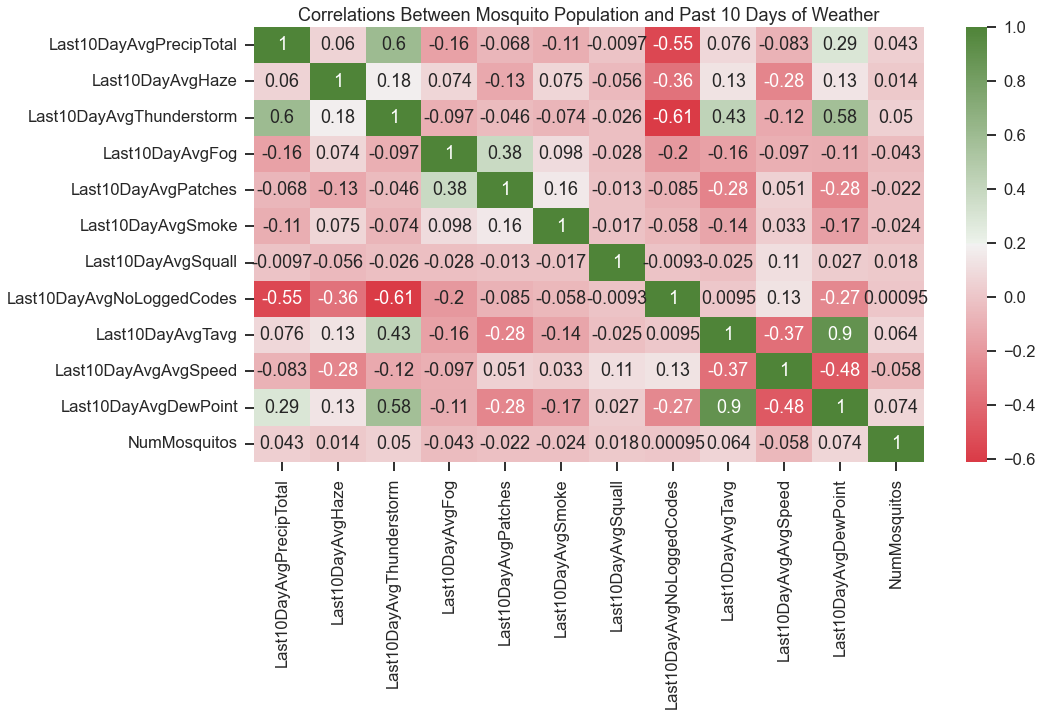

In [912]:
#create heatmap of correlation between values
sns.set_context('talk')
corr = MosqSumStations[['Last10DayAvgPrecipTotal','Last10DayAvgHaze','Last10DayAvgThunderstorm'
                   ,'Last10DayAvgFog','Last10DayAvgPatches','Last10DayAvgSmoke','Last10DayAvgSquall'
                   ,'Last10DayAvgNoLoggedCodes','Last10DayAvgTavg','Last10DayAvgAvgSpeed','Last10DayAvgDewPoint','NumMosquitos']].corr()
plt.figure(figsize = (15,8))
sns.heatmap(corr, cmap=sns.diverging_palette(10, 120, as_cmap=True), annot=True)
plt.title('Correlations Between Mosquito Population and Past 10 Days of Weather')
plt.show()
MosqSumStations.to_csv(r"C:\Users\johnd\Desktop\Excel Files\West Nile\MosquitosAndWeather.csv", index = False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             WnvPresent   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     22.36
Date:                Fri, 29 Jul 2022   Prob (F-statistic):           2.75e-26
Time:                        16:13:11   Log-Likelihood:                 723.82
No. Observations:                8610   AIC:                            -1434.
Df Residuals:                    8603   BIC:                            -1384.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.0212      0.030      0.701      0.483      -0.038       0.081
Species_CULEX ERRATICUS           -0.0212      0.195     -0.109      0.913      -0.404       0.361
Species_CULEX PIPIENS              0.0710      0.031      2.320      0.020       0.011       0.131
Species_CULEX PIPIENS/RESTUANS     0.0365      0.030      1.199      0.231      -0.023       0.096
Species_CULEX RESTUANS            -0.0013      0.031     -0.043      0.966      -0.061       0.059
Species_CULEX SALINARIUS          -0.0212      0.037     -0.575      0.566      -0.094       0.051
Species_CULEX TARSALIS            -0.0212      0.084     -0.252      0.801      -0.186       0.144
Species_CULEX TERRITANS           -0.0212      0.033     -0.643      0.520      -0.086       0.043
==============================================================================
Omnibus:                     6687.983   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            86611.092
Skew:                           3.892   Prob(JB):                         0.00
Kurtosis:                      16.447   Cond. No.                     3.78e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.14e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

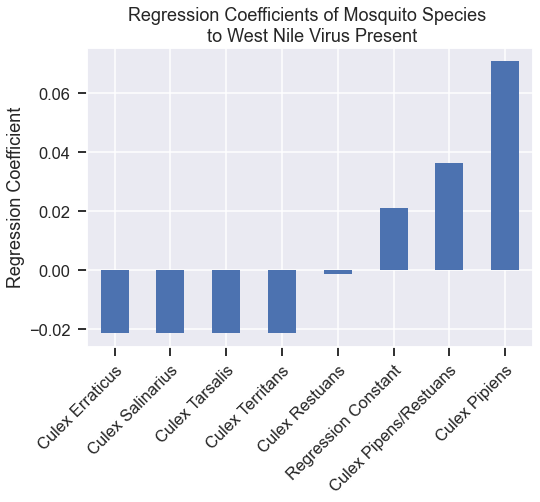

In [890]:
###explore mosquito species data to inspect for possible correlations. 
###its assumed that one species causes more cases than others

#split up species column into individual columns of binary results using pd.get_dummies
MosqSumStationsSpec = pd.get_dummies(MosqSumStations, columns = ['Species'])
#create chart of highest west nile virus regression coefficient per species
dep_var = MosqSumStationsSpec[['WnvPresent']]
indep_vars = MosqSumStationsSpec[['Species_CULEX ERRATICUS', 'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS','Species_CULEX TARSALIS', 'Species_CULEX TERRITANS']]
indep_vars_c = sm.add_constant(indep_vars1)
regression_model = sm.OLS(dep_var, indep_vars_c).fit()
fig, ax = plt.subplots()
regression_model1.params.sort_values().plot(kind='bar')
plt.title('Regression Coefficients of Mosquito Species \n to West Nile Virus Present')
ax.set_xticklabels(['Culex Erraticus', 'Culex Salinarius', 'Culex Tarsalis','Culex Territans', 'Culex Restuans', 'Regression Constant','Culex Pipens/Restuans', 'Culex Pipiens'])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylabel('Regression Coefficient')
regression_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
             Previous 10 Day Weather to Mosquito Regression Model             
==============================================================================
Dep. Variable:           NumMosquitos   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
No. Observations:                8610   F-statistic:                     8.150
Covariance Type:            nonrobust   Prob (F-statistic):           2.35e-14
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -2.1376     17.439     -0.123      0.902     -36.322      32.046
Last10DayAvgPrecipTotal      14.0768      6.985      2.015      0.044       0.385      27.769
Last10DayAvgHaze             11.5398      7.483      1.542      0.123      -3.129      26.209
Last10DayAvgThunderstorm     13.1921      6.907      1.910      0.056      -0.347      26.731
Last10DayAvgFog             -41.3316     18.105     -2.283      0.022     -76.822      -5.841
Last10DayAvgPatches          54.2760     48.458      1.120      0.263     -40.714     149.266
Last10DayAvgSmoke           -13.2938     23.296     -0.571      0.568     -58.960      32.372
Last10DayAvgSquall          196.6379    103.979      1.891      0.059      -7.186     400.462
Last10DayAvgNoLoggedCodes    21.9442      6.224      3.526      0.000       9.744      34.144
Last10DayAvgTavg             -0.5743      0.434     -1.322      0.186      -1.426       0.277
Last10DayAvgAvgSpeed         -2.4766      0.898     -2.757      0.006      -4.237      -0.716
Last10DayAvgDewPoint          1.0594      0.493      2.147      0.032       0.092       2.027
=============================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

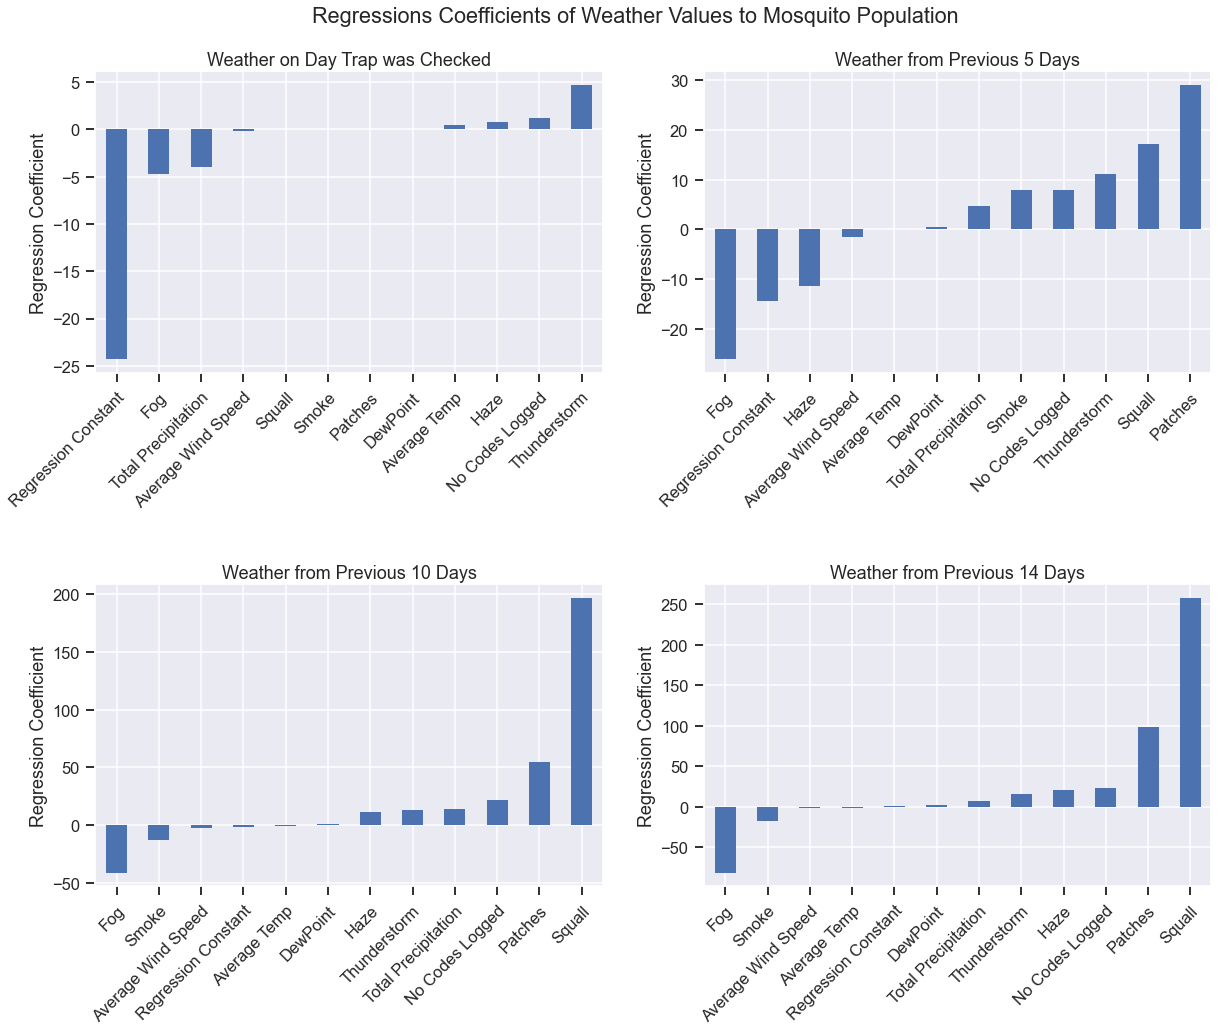

In [913]:
###explore rolling weather data to see if correlations exist

dep_var1 = MosqSumStations[['NumMosquitos']]
indep_vars1 = MosqSumStations[WeatherCon]
indep_vars_c1 = sm.add_constant(indep_vars1)
regression_modelcurr = sm.OLS(dep_var1, indep_vars_c1).fit()

dep_var2 = MosqSumStations[['NumMosquitos']]
indep_vars2 = MosqSumStations[WeatherCon5Day]
indep_vars_c2 = sm.add_constant(indep_vars2)
regression_modelFiveDay = sm.OLS(dep_var2, indep_vars_c2).fit()

dep_var3 = MosqSumStations[['NumMosquitos']]
indep_vars3 = MosqSumStations[WeatherCon10Day]
indep_vars_c3 = sm.add_constant(indep_vars3)
regression_modelTenDay = sm.OLS(dep_var3, indep_vars_c3).fit()

dep_var4 = MosqSumStations[['NumMosquitos']]
indep_vars4 = MosqSumStations[WeatherCon14Day]
indep_vars_c4 = sm.add_constant(indep_vars4)
regression_modelFourteenDay = sm.OLS(dep_var4, indep_vars_c4).fit()

sns.set_context('talk')

CurrReg = pd.DataFrame(data=regression_modelcurr.params.sort_values())
FiveDayReg = pd.DataFrame(data=regression_modelFiveDay.params.sort_values())
TenDayReg = pd.DataFrame(data=regression_modelTenDay.params.sort_values())
FourteenDayReg = pd.DataFrame(data=regression_modelFourteenDay.params.sort_values())

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(20,15))

CurrReg[0].plot.bar(ax=ax1, title='Weather on Day Trap was Checked')
FiveDayReg[0].plot.bar(ax=ax2, title='Weather from Previous 5 Days')
TenDayReg[0].plot.bar(ax=ax3, title='Weather from Previous 10 Days')
FourteenDayReg[0].plot.bar(ax=ax4, title='Weather from Previous 14 Days')

ax1.set_xticklabels(['Regression Constant', 'Fog', 'Total Precipitation', 'Average Wind Speed', 'Squall'
                              , 'Smoke', 'Patches', 'DewPoint', 'Average Temp', 'Haze'
                              , 'No Codes Logged', 'Thunderstorm'])
ax2.set_xticklabels(['Fog', 'Regression Constant','Haze', 'Average Wind Speed'
                     , 'Average Temp', 'DewPoint', 'Total Precipitation', 'Smoke', 'No Codes Logged', 'Thunderstorm', 'Squall', 'Patches'])
ax3.set_xticklabels(['Fog', 'Smoke', 'Average Wind Speed', 'Regression Constant', 'Average Temp', 'DewPoint','Haze'
                     , 'Thunderstorm', 'Total Precipitation', 'No Codes Logged', 'Patches', 'Squall'])
ax4.set_xticklabels(['Fog', 'Smoke', 'Average Wind Speed', 'Average Temp', 'Regression Constant', 'DewPoint'
                    , 'Total Precipitation', 'Thunderstorm','Haze', 'No Codes Logged', 'Patches', 'Squall'])

plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
plt.setp(ax4.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
plt.suptitle('Regressions Coefficients of Weather Values to Mosquito Population', y=.94)
plt.subplots_adjust(hspace=.7)
ax1.set_ylabel('Regression Coefficient')
ax2.set_ylabel('Regression Coefficient')
ax3.set_ylabel('Regression Coefficient')
ax4.set_ylabel('Regression Coefficient')

p_values = regression_modelTenDay.summary2().tables[1]['P>|t|']
p_values
regression_modelTenDay.summary(title='Previous 10 Day Weather to Mosquito Regression Model', slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Previous 10 Day Weather WNV Regression Model                 
==============================================================================
Dep. Variable:             WnvPresent   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
No. Observations:                8610   F-statistic:                     22.64
Covariance Type:            nonrobust   Prob (F-statistic):           2.27e-46
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.0226      0.057     -0.400      0.689      -0.133       0.088
Last10DayAvgPrecipTotal       0.0553      0.023      2.444      0.015       0.011       0.100
Last10DayAvgHaze             -0.0712      0.024     -2.938      0.003      -0.119      -0.024
Last10DayAvgThunderstorm     -0.0091      0.022     -0.407      0.684      -0.053       0.035
Last10DayAvgFog              -0.1054      0.059     -1.797      0.072      -0.220       0.010
Last10DayAvgPatches           0.2371      0.157      1.510      0.131      -0.071       0.545
Last10DayAvgSmoke            -0.0263      0.075     -0.348      0.728      -0.174       0.122
Last10DayAvgSquall           -0.8538      0.337     -2.534      0.011      -1.514      -0.193
Last10DayAvgNoLoggedCodes     0.0805      0.020      3.992      0.000       0.041       0.120
Last10DayAvgTavg             -0.0090      0.001     -6.381      0.000      -0.012      -0.006
Last10DayAvgAvgSpeed         -0.0102      0.003     -3.510      0.000      -0.016      -0.005
Last10DayAvgDewPoint          0.0131      0.002      8.194      0.000       0.010       0.016
=============================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

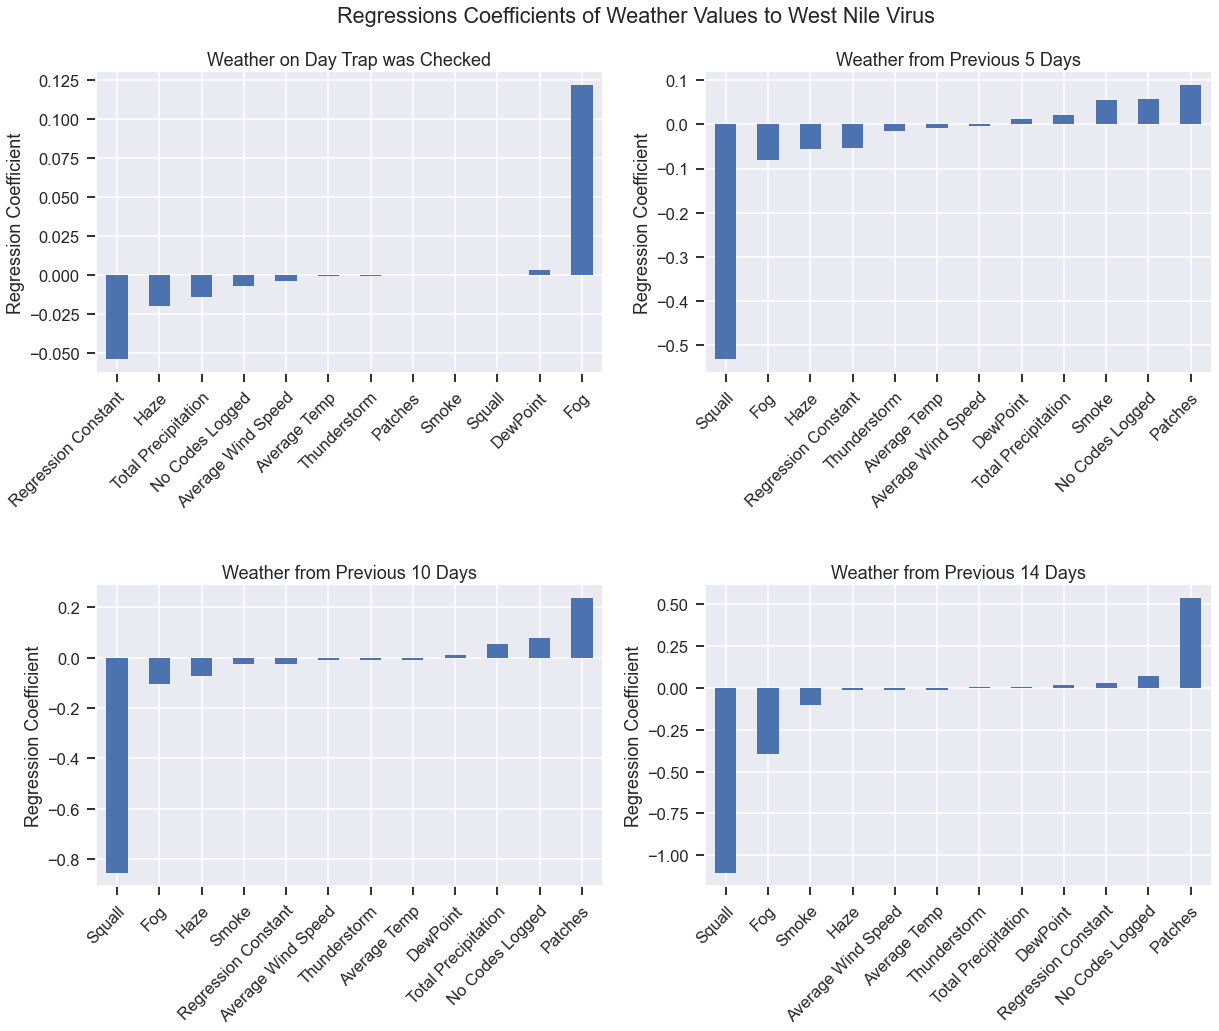

In [894]:
###do the same thing with weather values to West Nile Virus

dep_var5  = MosqSumStations[['WnvPresent']]
regression_modelcurrWNV = sm.OLS(dep_var5, indep_vars_c1).fit()

dep_var6 = MosqSumStations[['WnvPresent']]
regression_modelFiveDayWNV = sm.OLS(dep_var6, indep_vars_c2).fit()

dep_var7 = MosqSumStations[['WnvPresent']]
regression_modelTenDayWNV = sm.OLS(dep_var7, indep_vars_c3).fit()

dep_var8 = MosqSumStations[['WnvPresent']]
regression_modelFourteenDayWNV = sm.OLS(dep_var8, indep_vars_c4).fit()

CurrRegWNV = pd.DataFrame(data=regression_modelcurrWNV.params.sort_values())
FiveDayRegWNV = pd.DataFrame(data=regression_modelFiveDayWNV.params.sort_values())
TenDayRegWNV = pd.DataFrame(data=regression_modelTenDayWNV.params.sort_values())
FourteenDayRegWNV = pd.DataFrame(data=regression_modelFourteenDayWNV.params.sort_values())

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(20,15))

CurrRegWNV[0].plot.bar(ax=ax1, title='Weather on Day Trap was Checked')
FiveDayRegWNV[0].plot.bar(ax=ax2, title='Weather from Previous 5 Days')
TenDayRegWNV[0].plot.bar(ax=ax3, title='Weather from Previous 10 Days')
FourteenDayRegWNV[0].plot.bar(ax=ax4, title='Weather from Previous 14 Days')
ax1.set_xticklabels(['Regression Constant', 'Haze', 'Total Precipitation', 'No Codes Logged', 'Average Wind Speed', 'Average Temp'
                     , 'Thunderstorm', 'Patches', 'Smoke', 'Squall', 'DewPoint', 'Fog'])
ax2.set_xticklabels(['Squall','Fog','Haze', 'Regression Constant', 'Thunderstorm', 'Average Temp', 'Average Wind Speed'
                     , 'DewPoint', 'Total Precipitation', 'Smoke', 'No Codes Logged','Patches'])
ax3.set_xticklabels(['Squall','Fog','Haze', 'Smoke', 'Regression Constant', 'Average Wind Speed', 'Thunderstorm', 'Average Temp'
                     , 'DewPoint', 'Total Precipitation', 'No Codes Logged','Patches'])
ax4.set_xticklabels(['Squall','Fog', 'Smoke','Haze', 'Average Wind Speed', 'Average Temp', 'Thunderstorm'
                     , 'Total Precipitation', 'DewPoint', 'Regression Constant', 'No Codes Logged','Patches'])
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
plt.setp(ax4.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
plt.suptitle('Regressions Coefficients of Weather Values to West Nile Virus', y=.94)
plt.subplots_adjust(hspace=.7)
ax1.set_ylabel('Regression Coefficient')
ax2.set_ylabel('Regression Coefficient')
ax3.set_ylabel('Regression Coefficient')
ax4.set_ylabel('Regression Coefficient')
regression_modelTenDayWNV.summary(title='Previous 10 Day Weather WNV Regression Model', slim=True)

In [ ]:
#Attempting to join spray data to mosquito data to measure efficacy of sprays

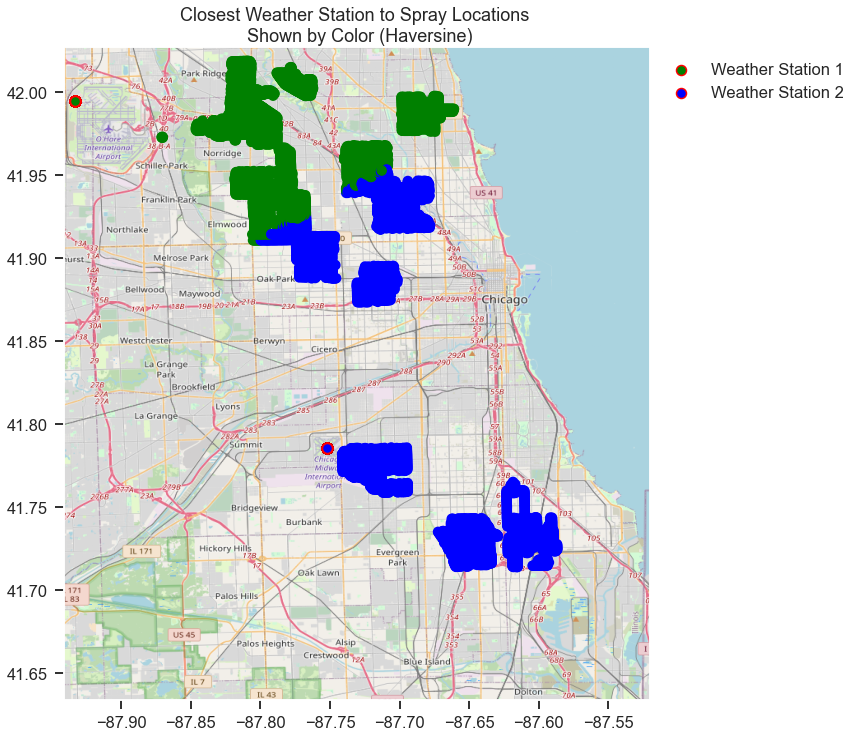

In [918]:
#add distance to each station to mosquito dataframe
spray['Dist_To_Station1'] = spray.apply(lambda row: haversine(-87.933, 41.995, row['Longitude'], row['Latitude']), axis=1)
spray['Dist_To_Station2'] = spray.apply(lambda row: haversine(-87.752, 41.786, row['Longitude'], row['Latitude']), axis=1)
#subtract distance 1 from distance 2. if number is negative, the closest station is station 1, else 2
spray['Dist_diff'] = spray['Dist_To_Station1'].sub(spray['Dist_To_Station2'], axis = 0)
result = []       
for x in spray['Dist_diff']:
    if x < 0:
        result.append(1)
    else:
        result.append(2)
spray['Closest_Station'] = result 
sprayColor = []
for x in spray['Closest_Station']:
    if x == 1: sprayColor.append('green')
    else: sprayColor.append('blue')
spray['sprayColor'] = sprayColor
Dimensions = (-87.9410, -87.5200, 41.6340, 42.0270)
sns.set_context('talk')
Chicago = plt.imread('map (4).png')
fig, ax = plt.subplots(figsize = (10.5,12))
ax.imshow(Chicago, extent = Dimensions, aspect ='auto')
sns.set_context()
#color mosquito traps by which station is closer
ax.scatter(spray.Longitude, spray.Latitude, c=spray.sprayColor)
ax.scatter(Station1.Long, Station1.Lat, c='green', s=100, label='Weather Station 1', edgecolors='red')
ax.scatter(Station2.Long, Station2.Lat, c='blue', s=100, label='Weather Station 2', edgecolors='red')
ax.grid(False)
ax.set_title('Closest Weather Station to Spray Locations \n Shown by Color (Haversine)')
ax.set_xlim(Dimensions[0],Dimensions[1])
ax.set_ylim(Dimensions[2],Dimensions[3])
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.savefig('closest_station')

In [ ]:
#group sprays by individual spray events and their dates. convert Date field to datetime and sort by Date
spray1 = spray.groupby(['Spray', 'Date'])[['Latitude', 'Longitude']].mean().reset_index()
spray1['Date'] = pd.to_datetime(spray1['Date'])
spray1 = spray1.sort_values(by='Date').reset_index(drop=True)
spray1.head(10)
#merge sprays with trap checks within 2 weeks. No exact matches due sprays happening at night after traps have been checked
MosqSum = MosqSum.sort_values(by='Date').reset_index(drop=True)
MosSpray = pd.merge_asof(MosqSum, spray1, on= 'Date', allow_exact_matches=False
                         , direction='backward', tolerance=pd.Timedelta(days=14))
MosqSum['Date'] = pd.to_datetime(MosqSum['Date'])

In [ ]:
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r


